# Simulating Neutron Transport and Scattering via Monte Carlo Methods
Rosie Schiffmann <br>
11020606 <br>
University of Manchester <br>
April 2024

In [2]:
#import python libraries
from codecarbon import EmissionsTracker
import numpy as np
import matplotlib.pyplot as plt 
import scipy.constants as pc

# Abstract

This report aims to simulate thermal neutrons incident normally onto a sheilding layer, and to calculate the proportion of neutrons that are transmitted, absorbed or reflected by the shielding layer. This was investigated for water, lead and graphite shielding layers. In order to simulate the chaotic nature of neutron transport and scattering, random numbers were generated according to the corresponding distirbutions that describe the macro properties of neutron behavior. By fitting a straight line to randomly generated data distibuted to a linearlised exponential equation, constants such as the mean free path of water, and characteristic attenuation lengths of water, lead and graphite were calculated, along with the corresponding errors.

# Introduction

# 1. Preliminaries

# 1.1 Random number generators

One common type of 'pseudo' random number generator is the linear congruential generator (LCG). This generatres a sequence of numbers that exhibit statistical randomness, by using the following equation and parameters:

$$X_{n+1} = (a X_n + c)\mod m$$
where $a$ is the multiplier, $c$ is th increment, $m$ is the modulus and
$$m > 0,$$
$$0 \leq a < m,$$
$$0 < c < m,$$
$$0 \leq X_0 < m.$$

The 'pseudo' random nature of numbers generated by an LCG is due to the fact that the entire sequence is deterministic. Given the parameters $a$, $c$, $m$ and the value of $X_0$ (the 'seed' of the LCG), every number in the sequence can be calculated. Furthermore, the sequence is periodic and repeats itself over a period of $m$ numbers. 

All LCGs are known to cause correlation when generating large sets of numbers. For example, 3D points generated by an LCG can all lay on discrete spectral planes rather than occupying the entire 3D space uniformly. However, as long as any the correlation doesn't affect the measurements being made, then LCGs can still be used to generate pseudo random numbers for calculations.

One LGC, 'RANDSSP', is known to generate points that lie on diecrete planes in 3D. It is based on the parameters used by IBM's Scientific Subroutine Package, and is functionally implemented below.

In [18]:


def randssp(p,q):
    '''
    Generates a (p,q) sized matrix of pseudo random numbers, using an LCG algothithm. 
    Generated numbers are known to exhibit correlation.
    
    Parameters:
    p: float
    q: float
    
    Returns:
    r: array of floats
    '''
    try: x
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        x = 123456789
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m
    return r

Another type of random number generator is pythons in-built random number generator 'numpy.random.uniform()'. This function is able to generate uniformly distributed random numbers. The standard deviation from the mean is calculated for data sets of different sizes. There is a constant theoretical probability of a value being in a given bin of $p = 1 / n$, where $n$ is the number of bins. As there are only 2 outcomes per value (inside given bin, not inside given bin) we can use the binomial distibution to calculate the standard deviation $\sigma$ of each data set:

$$ \sigma = \sqrt{np(1-p)}$$

Therefore, a for smaller deviation from the theoretical mean for each bin, a larger sample size is required. This dependency is demonstrated by histograms for different sized sets of randomly generated numbers.

In [19]:
#define array of sample sizes to plot
sample_sizes = np.array([100, 1000, 10000, 100000])

#define number of bins
number_of_bins = 10

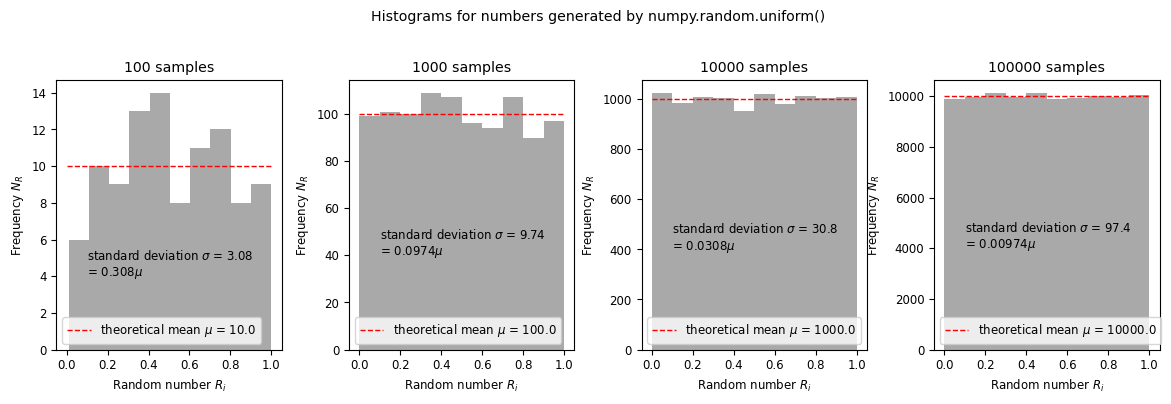

In [20]:
#making plot non-interactive
%matplotlib inline

def std_uniform_generation(sample_size, bin_number):
    '''
    Calculates the standard deviation from the theoretical mean number of values in each bin using the binomial distribution,
    for uniform randomly generated numbers.

    Parameters:
    sample_size: int
    bin_number: int
    '''
    probability = 1 / bin_number
    variance = sample_size * probability * np.sqrt(1 - probability)
    std = np.sqrt(variance)
    return std 

def plot_uniform_histograms(sample_sizes, bin_number):
    '''
    Plots 4 histograms for random numbers generated bu numpy.random.uniform(), using specified range of sample sizes and
    specified bin number

    Parameters:
    sample_size: array of int
    bin_number: int

    Returns:
    None
    '''
    #set up plot
    plt.style.use('default') 
    plt.rcParams["figure.figsize"] = (12,4)
    plt.rcParams.update({'font.size':8.5})
    fig, ax = plt.subplots(1, 4)
    fig.suptitle('Histograms for numbers generated by numpy.random.uniform()')
    fig.tight_layout(pad=2.5)

    #plot histograms for different sample sizes
    for i in range(len(sample_sizes)):
        values = np.random.uniform(size = sample_sizes[i])
        ax[i].hist(values, bins = bin_number, color = 'darkgray')
        ax[i].set_title(f'{sample_sizes[i]} samples')
        ax[i].set_xlabel('Random number $R_i$')
        ax[i].set_ylabel('Frequency $N_R$')
        
        #add line to indicate theoretical mean and annotate the standard deviation onto the plot
        ax[i].hlines(sample_sizes[i]/bin_number, 0, 1, linestyle = '--', color = 'red', linewidth = 1, 
                     label = rf'theoretical mean $\mu$ = {sample_sizes[i]/bin_number}')
        ax[i].legend(loc = 'lower left')
        ax[i].annotate(rf"""standard deviation $\sigma$ = {std_uniform_generation(sample_sizes[i], bin_number):2.3} 
= {std_uniform_generation(sample_sizes[i], bin_number)/(sample_sizes[i]/bin_number):2.3}$\mu$""", 
                       (0.1, sample_sizes[i]/25))
    plt.show()
    return None

#plot histograms for using 10 bins and sample sizes as specfied above
plot_uniform_histograms(sample_sizes, number_of_bins)

The above plots confirm that as sample size increases, the standard deviation as a proportion of the theoretical mean decreases, meaning that the counts per bin lie proportionately close to the theoretical counts per bin for larger sample sizes. Therefore, for the later parts of this investigation, a large sample size (many neutrons) will be incident onto the shielding material in order to minimise large fluctuations in generated 

# 1.2 3D randomly generated coordinates

We will now compare the numpy.random.uniform() and 'RANDSSP' methods for generating points in 3D. We expect to see correlation in the form of points lying on discrete 3D planes for points generated using the LCG. Plots of points generated by both methods are displayed below.

In [6]:
#define number of points to plot  
points = 5000

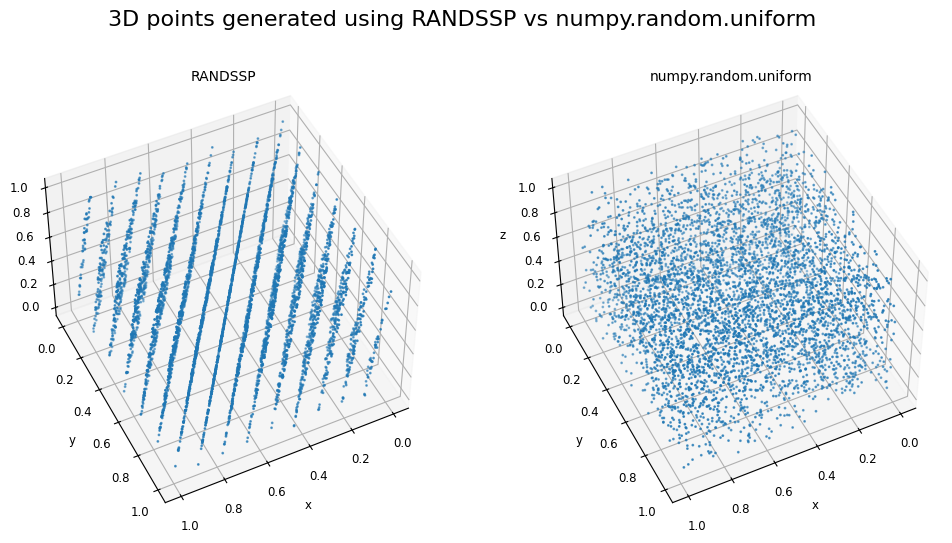

In [7]:
#create 3D plotting 
from mpl_toolkits.mplot3d import Axes3D

#set out subplots
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots(1,2, subplot_kw={'projection':'3d'})
fig.suptitle('3D points generated using RANDSSP vs numpy.random.uniform', fontsize = 16, font = 'DejaVu Sans')

#generate coordinates using both methods of random number generation
randssp_x, randssp_y, randssp_z = np.split(randssp(3,points), 3, axis=0)
np_random_x, np_random_y, np_random_z = np.split(np.random.uniform(size = (3,points)), 3, axis=0)

#plot points on each subplot
ax[0].scatter(randssp_x, randssp_y, randssp_z, s=1)
ax[1].scatter(np_random_x, np_random_y, np_random_z, s = 1)
              
#create subtitles for each interactve subplot              
ax[0].set_title('RANDSSP', fontsize = 10)
ax[1].set_title('numpy.random.uniform', fontsize = 10)

#create initial orientation that displays spectral planes for ranssp method and
#label axes for each plot
for i in range(2):
    ax[i].view_init(48, 64)
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_zlabel('z')
plt.show()



Points generated using the 'RANDSSP' algorithm all lie on discrete 3D planes due to the LCG method that it implements. Whilst pseudo random numbers generated by LCGs can be used for certain projects where this correlation doesnt affect what is measured, in this project random numbers will be generated using the numpy.random.uniform() number generator. This method generates no visual spectral issues, and therefore no apparent correlation.

# 1.3 Generating isotropic vectors

In order to accurately simulate neutron movement inside the shielding material, the program needs to be able to generate isotropic vectors, meaning uniformly distributed direction vectors that are equally likely to be in any direction. This can be done by generating random values for $\theta$ and $\phi$ in spherical polar coordinates, whilst keeping $r$ constant. When plotted, a uniform density spherical shell should form. However, the situation is not as simple as this.

If these generated polar coordinates are converted into cartesian points, there becomes a higher denisty at the highest and lowest $z$ values, or the poles of the sphere. As $z = rcos(\theta)$, this phenomena occurs due to the shape of the $cos(\theta)$ function at the boundaries, $0<\theta<\pi$. This function has a smaller gradient closer to the boundaries, meaning that values of $\theta$ near the boundaries are more likely to be generated that values of $~\pi/2$. 

In order to oppose this bias, the randomly generated values of $\theta$ should be distributed according the the function $\theta_i = \arccos(1-2R_i)$ with $R_i$ uniformly distributed between 0 and 1. This function has larger gradient closer to the boundaries, meaning that it opposes the bias created by generating uniformly random $\theta$ values and calculating $z = rcos(\theta)$. Both cases are plotted below.

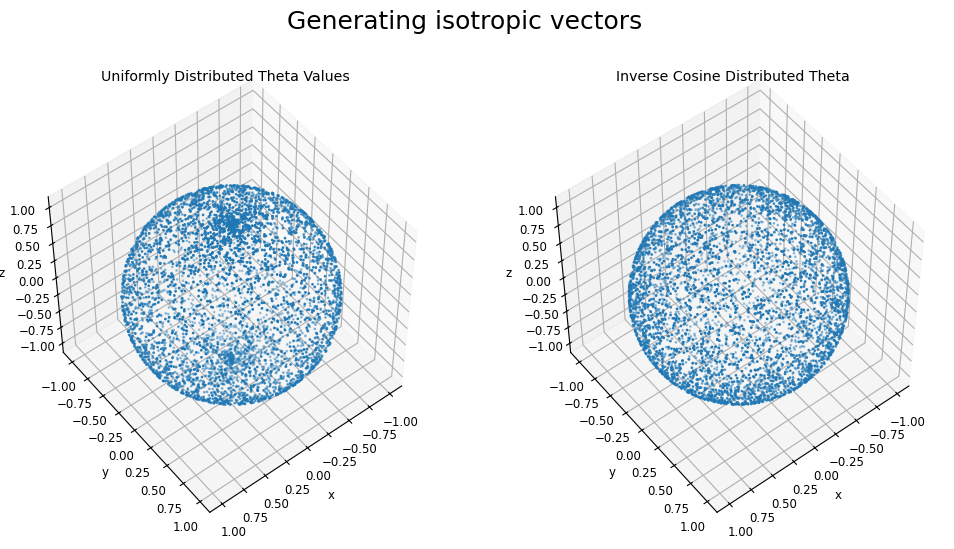

In [8]:
def polar_to_cartesian(thetas, phis, r):
    '''
    Generates array of x, y and z (cartesian) coordinates calculated from inputted polar coordinates.
    
    Parameters:
    thetas: 1D array of floats
    phis: 1D array of floats
    r: 1D array of floats
    
    Returns:
    x_array: 1D array of floats
    y_array: 1D array of floats
    z_array: 1D array of floats
    '''
    x_array = r * np.sin(thetas) * np.cos(phis)
    y_array = r * np.sin(thetas) * np.sin(phis)
    z_array = r * np.cos(thetas)
    return x_array, y_array, z_array

def generate_thetas(n):
    '''
    Generates n randomly generated theta values distibuted according to an arccos function, in order to create isotropic
    polar coordinates.
    
    Paramerers:
    n: int
    
    Returns:
    theta_array: 1D array of floats
    '''
    theta_array = np.arccos(1 - 2 * np.random.uniform(0, 1, size = n))
    return theta_array

def plot_comparison(n):
    '''
    Plots n 3D randomly generated vectors generated using a uniform distribution of theta values or an arccos distributed array 
    of theta values to demonstrate if the vectors are isotropic.
    
    Parameters:
    n: int
    
    Returns:
    None
    '''
    #set up plots
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax = plt.subplots(1,2, subplot_kw={'projection':'3d'})
    fig.suptitle('Generating isotropic vectors', font = 'DejaVu Sans', fontsize = 18)
    
    #generate uniform and arccos weighted distributions of theta
    theta_uniform = np.random.uniform(0, np.pi, size = n)
    theta_weighted = generate_thetas(n)
    
    #generate uniform phi array
    phi_array = np.random.uniform(0, 2*np.pi, size = n)
    
    #convert polar vectors into cartesian vectors
    x,y,z = polar_to_cartesian(theta_weighted, phi_array, 1)
    x_bias, y_bias, z_bias =  polar_to_cartesian(theta_uniform, phi_array, 1)
    
    #plot vectors and set titles
    ax[0].scatter(x_bias, y_bias, z_bias, s = 1)
    ax[0].set_title('Uniformly Distributed Theta Values')
    ax[1].scatter(x, y, z, s = 1)
    ax[1].set_title('Inverse Cosine Distributed Theta')
    
    #add details to plots
    for i in range(2):
        ax[i].set_xlabel('x')
        ax[i].set_ylabel('y')
        ax[i].set_zlabel('z')
        ax[i].set_box_aspect([5,5,5])
        ax[i].view_init(52, 52)
    plt.show()
    return None

plot_comparison(points)

As demonstrated above, the poles of the sphere generated from uniformly distributed $\theta$ are more dense than the rest of the sphere. This bias has been eliminated in the other plot, where $\theta$ values were distributed according to an inverse cosine function in order to counteract the bias previously demonstrated. This sphere is of uniform denisty, suggesting vectors are isotropic and equally likely to be in any direction.

# 1.4 Exponentially Distributed Random Numbers

The probability that any given thermal neutron will travel a certain distance inside the sheilding material before it interacts with a particle can be represented through an exponential distribution, scaled by the mean free path $\lambda$. Therefore, we need to be able to randomly generate numbers that are distributed according to an exponential function in order to simulate neutron attenuation in the absence of scattering inside the sheilding material.

To create exponentially distributed random numbers, we find the  inverse cumulative distribution function ($CDF^{-1}$) of an exponential probability distribution function ($PDF$), and use the uniformly distributed numbers to calculate the value of the $CDF^{-1}$:

$$ PDF(x) = e^{\frac{-x}{\lambda}},$$
$$ CDF(x) = \lambda(1-e^{\frac{-x}{\lambda}}),$$
$$ CDF^{-1}(z) = -\lambda \ln{(1- \frac{z}{\lambda})},$$

where we replace $z$ with uniformly distributed random number $R_i$. As $(1- \frac{R_i}{\lambda})$  is a random number and its only requirement is to be random, we can replace this expression by $R_i$ to simplify it. This gives exponentially distributed randomly generated numbers $S_i$, where

$$ S_i = -\lambda \ln(R_i).$$

We will use this randomly generated exponential distribution to generate the characteristic attenuation length of thermal neutrons in water in the absence of scattering (equivalent to generating mean free path $\lambda$). The mean free path of thermal neutrons in water $\lambda_{true}$ is known to be 0.450 m. The relationship describing the attenuation of thermal neutrons in water in the absence of scattering is 
$$N(x) = N_{0} exp(\frac{-x}{\lambda}),    \quad (1)$$
where $N(x)$ is the number of neutrons not absorbed after travelling distance $x$ and $N_{0}$ is the initial number of neutrons. This can be rearranged to obtain a linear relationship in $x$, 
$$ln(N(x)) = \frac{-x}{\lambda} + ln(N_{0}).   \quad  (2)$$
By plotting the data in this form, a line can be fitted to the data in order to generate values for $\lambda$ and $N_{0}$.

In [9]:
# define mean free path of water
MFP_WATER = 0.450 # metres

# define sample size
sample_size = 10000

#define number of bins
num_of_bins = 50

#define number of repeats
repeats = 500

#define the maximum attenuration of neutrons
max_attenuation = 3 # metres

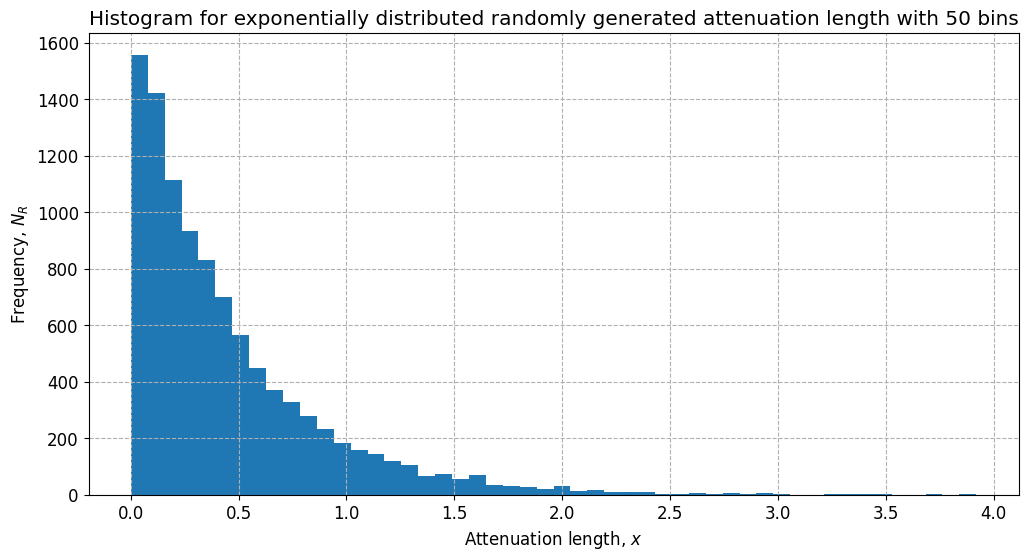

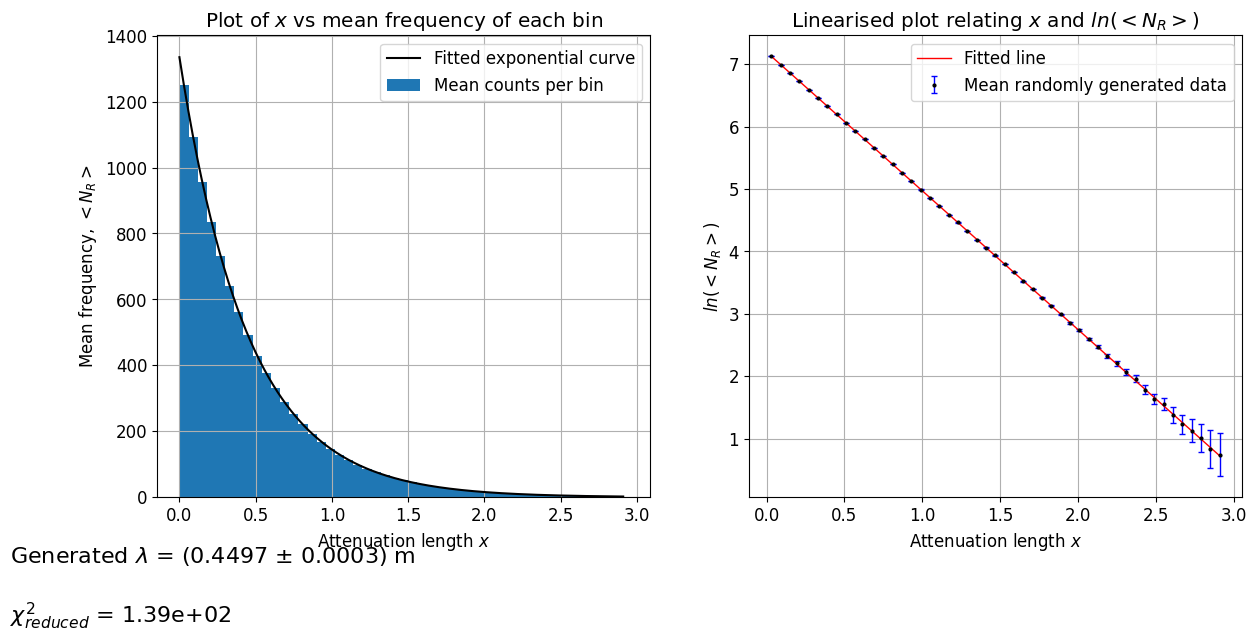

In [21]:
def exponential_number_generator(n, mean_free_path = MFP_WATER):
    '''
    Generates n exponentially distributed random numbers.
    
    Parameters:
    n: int
    mean_free_path: float
    
    Returns:
    exp_array:array of floats
    '''
    uniform_array = np.random.uniform(size = n)
    exp_array = - mean_free_path * np.log(uniform_array)
    return exp_array

def mean_counts(n, bin_number, number_of_repeats, r_max):
    '''
    Generates the mean and error of the number of counts in each bin using a given number of repeats 
    using n exponentially distributed random numbers and (bin_number) bins, and calculates the mid-point of each bin, up
    to a maximum attenuation  length r_max.
    
    Parameters:
    n: int
    bin_number: int
    number_of_repeats: int
    r_max: float
    
    Returns:
    avg_counts: array of floats
    bin_centre: array of floats
    counts_error: array of floats
    '''
    #create arrays for mean counts per bin, error and bin centres
    counts, bin_boundaries = np.empty((0,bin_number)), np.empty((0,bin_number+1))
    
    for i in range(number_of_repeats):
        counts_temp, bin_boundaries_temp = np.histogram(exponential_number_generator(n), bins = bin_number, range = (0,r_max))
        counts = np.vstack((counts, counts_temp))
        bin_boundaries = np.vstack((bin_boundaries, bin_boundaries_temp))
        
        
    #calculate the number of counts per bin and error associated    
    avg_counts = np.empty(bin_number)
    counts_error = np.empty(bin_number)
    for i in range(bin_number):
        avg_counts[i] = np.mean(counts[:,i])
        counts_error[i] = np.std(counts[:,i]) / avg_counts[i]
        
    #calculate the edge of each bin from the mean
    avg_boundary = np.empty(bin_number+1)
    for i in range(bin_number+1):
        avg_boundary[i] = np.mean(bin_boundaries[:,i])
        
    #calculate the mid point of each bin
    bin_centre = np.empty(bin_number)
    for i in range(bin_number):
        bin_centre[i] = (avg_boundary[i+1] - avg_boundary[i]) / 2 + avg_boundary[i]
        
    #delete values in each array where error = 0 
    bin_centre = np.delete(bin_centre, np.where(counts_error == 0))[:-1]
    avg_counts = np.delete(avg_counts, np.where(counts_error == 0))[:-1]
    counts_error = np.delete(counts_error, np.where(counts_error == 0))[:-1]

    return avg_counts, bin_centre, counts_error

def plot_random_exponential_dist(n, bin_number):
    '''
    Plots a histogram for n exponentially distributed randomly generated numbers with bin_number bins
    
    Parameters:
    n: int
    bin_number: int
    
    Returns:
    None
    '''
    #set up plot
    plt.rcParams.update({'font.size':12})
    plt.rcParams["figure.figsize"] = (12,6)
    plt.figure()
    
    #plot histogram for one iteration
    plt.hist(exponential_number_generator(n), bins = bin_number)
    
    #add details to histogram
    plt.grid(linestyle = '--')
    plt.xlabel('Attenuation length, $x$')
    plt.ylabel('Frequency, $N_R$')
    plt.title(f'Histogram for exponentially distributed randomly generated attenuation length with {bin_number} bins')
    return None

def calculate_parameters(n, bin_number, number_of_repeats, r_max):
    '''
    Calculates parameters and associated covariances associated with the linear fit to the mean counts per bin for
    number_of_repeats repeats of n exponentially distributed randomly generated numbers.
    
    Parameters:
    n: int
    bin_number: int
    number_of_repeats: int
    r_max: float
    
    Returns:
    gradient: float
    intercept: float
    cov_matrix: 2D array of floats
    ''' 
    #calculate mean counts, error and mid points of bins
    means, bin_centres, N_errors = mean_counts(n, bin_number, number_of_repeats, r_max)
    
    #error of ln(x) is fractional error on x
    ln_N_errors = N_errors/means
    
    #calculate gradient intercept and corresponding errors for a linear fit
    (gradient, intercept), cov_matrix = np.polyfit(bin_centres, np.log(means), 1, w = (1/ln_N_errors), cov=True)
    
    return gradient, intercept, cov_matrix

def reduced_chi_squared(data, errors, fit):
    '''
    Returns the reduced chi squared for a set of data and assoiated error compared to the modelled fit.
    
    Parameters:
    data: array of floats
    errors: array of floats
    fit: array of floats
    
    Returns:
    red_chi_sq: float
    '''
    red_chi_sq = np.sum((data - fit)**2 / errors**2) / len(data)
    return red_chi_sq

def plot_averaged_exponential_dist(n, bin_number, number_of_repeats, r_max):
    '''
    Plots the mean counts per bin for number_of_repeats repeats of n exponentially distributed randomly generated numbers, 
    with a max number (attenuation length in water) of r_max. Also plots linearised fit and associated errors in the form 
    of equation (2), along with the calculated parameter (mean free path)
    
    Parameters:
    n: int
    bin_number: int
    number_of_repeats: int
    r_max: float
    '''
    #define mean values of N, bin mids and error associated with each N
    means, bins, errors = mean_counts(n, bin_number, number_of_repeats, r_max)
    
    #error associated with ln(x) is the fractional error on x for x_error << x
    ln_N_errors = errors/means
    
    #find parameters from fitting linearly to data
    gradient, intercept, cov_matrix = calculate_parameters(n, bin_number, number_of_repeats, r_max)
    mfp = -1/gradient
    gradient_error = np.sqrt(np.diag(cov_matrix)[0])
    mfp_err = np.sqrt(mfp**2 * gradient_error**2 / gradient**2)
    initial_N = np.exp(intercept)
    fit = np.polyval((gradient, intercept), bins)
    
    #create subplots
    plt.rcParams["figure.figsize"] = (14,6)
    fig, ax =  plt.subplots(1,2)
    
    #create linear fitted plot according to equation (2)
    ax[1].errorbar(bins, np.log(means), yerr = ln_N_errors, fmt = 'o', color = 'black', markersize = 2, 
                   capsize = 2, linewidth =1, ecolor ='blue', label = 'Mean randomly generated data')
    ax[1].plot(bins, fit, c = 'red', linewidth = 1, label = 'Fitted line')
    ax[1].set_ylabel('$ln(<N_{R}>)$')
    ax[1].set_title('Linearised plot relating $x$ and $ln(<N_R>)$')
   
    #plot exponential plot according to equation (1)
    ax[0].bar(bins, means, width = bins[1]-bins[2], label = 'Mean counts per bin')
    ax[0].plot(np.linspace(0,bins[-1],300), initial_N * np.exp(-np.linspace(0,bins[-1],300)/mfp), c = 'black',  
               label = 'Fitted exponential curve')
    ax[0].set_ylabel('Mean frequency, $<N_R>$')
    ax[0].set_title('Plot of $x$ vs mean frequency of each bin')
    
    #plot details
    for i in range(2):
        ax[i].legend()
        ax[i].grid()
        ax[i].set_xlabel('Attenuation length $x$')
        
    #print parameter and chi squared values
    fig.text(0.02, -0, rf'Generated $\lambda$ = ({mfp:2.4} $\pm$ {mfp_err:2.1}) m', fontsize = 16)
    reduced_chi_sq = reduced_chi_squared(np.log(means), ln_N_errors, fit)
    fig.text(0.02, -0.1, r'$\chi_{reduced}^2$' + rf' = {reduced_chi_sq:2.3}', fontsize = 16)
    return None

plot_random_exponential_dist(sample_size, num_of_bins)
plot_averaged_exponential_dist(sample_size, num_of_bins, repeats, max_attenuation)

The calculated mean free path of thermal neutrons is consistent with the estimate of 45cm. Due to errors being scaled by the mean counts per bin, errors are largest ar the higher values of $x$. For the majority of points, errors are very small, suggesting very small fluctuations in the mean counts per bin over the 500 repeats. This is reflected in the large $\chi_{reduced}^2$.

# 1.5 Generating Exponential Isotropic Vectors

Having generated both isotropic vectors of unit length, and exponentially distributed distances, we will now combine these to create an isotopic exponential number generator.

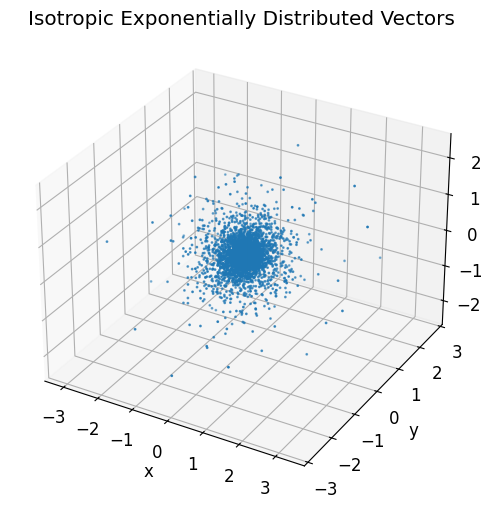

In [22]:
def isotropic_exponential_vectors(n, mean_free_path = MFP_WATER):
    '''
    Generates cartesian coordinates for n exponentially distributed isotropic vectors, scaled to the mean_free_path.
    
    Parameters:
    n: int
    mean_free_path: float
    
    Returns:
    x: array of floats
    y: array of floats
    z: array of floats
    '''
    #create exponentially generated magnitudes of vectors
    r_array = exponential_number_generator(n, mean_free_path)
    
    #generate uniformly distributed random phi values
    phi = np.random.uniform(0, 2*np.pi, size = n)
    
    #generate arccos weighted theta values
    theta = generate_thetas(n)
    
    #convert from polar coords to cartesian
    x,y,z = polar_to_cartesian(theta, phi, r_array)
    return x, y, z

def plot_3d_scatter(x_array, y_array, z_array, title):
    '''
    Plots a 3D scatter graph according to inputted x_array, y_array and z_array coordinates.
    
    Parameters:
    x_array: array of floats
    y_array: array of floats
    z_array: array of floats
    title: str
    '''
    #set up plots
    fig, ax =  plt.subplots(1,1, subplot_kw={'projection':'3d'})
    plt.rcParams["figure.figsize"] = (6,4)
    
    #plot isotropic vectors
    ax.scatter(x_array, y_array, z_array, s = 1)
    
    #add axis labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(f'{title}')
    plt.show()
    return None
    
x, y, z = isotropic_exponential_vectors(points)
plot_3d_scatter(x, y, z, 'Isotropic Exponentially Distributed Vectors')  

Vectors generated by the isotropic exponential generator have no bias in direction, and the magnitdues are exponentially distributed with smaller magnitudes being more common than large magnitudes. This is demonstrated in the plot above.

# 2 Simulating Neutron Penetration

# 2.1 Cross Sections and Mean Free Path

The first step in simulating the behavior of thermal neutrons inside the sheilding material is to determine the macroscopic scattering and absorbtion cross sections, as well as the mean free path of neutrons.

The intensity (number per unit area) of neutrons that are scattered $I_s$ or absorbed $I_a$ inside a thin layer of material of unit thickness $L$ is defined by 

$$I_{s/a} = n \sigma_{s/a} I_0 L, \quad(3)$$

where $n$ is the number denisty of sheilding material, $\sigma_{s/a}$ is the microscopic scattering / absorbtion cross section and $I_0$ is the intensity of neutrons initially entering the layer. The number density can be calculated via


$$n = \frac{\rho N_A}{M},$$


where $\rho$ is the density of the sheilding material, $N_A$ is Avogadro's constant and $M$ is the molar mass of the sheilding material.

From equation (3), the rate of scattering / absorbtion per unit thickness of material

$$R = - \frac{d I}{dx} = n \sigma_{s/a} I. \quad(4) $$

Solving differential equation (4) gives

$$ I(x) = I_0 e^{-n {\sigma_{s/a} x}} = I_0 e^{-\frac{x} {\lambda_{s/a}}},$$

where the mean free path for scattering / absorbtion $\lambda_{s/a}$ = $\frac{1}{n{\sigma_{s/a}}}$.

In order to calculate useful quantites like the probability of scattering or absorbtion for a single interaction , or the total mean free path for a particle inside a material when both scattering and absorbtion processes are considered, the macroscopic cross section is required. The macroscopic cross sections of scattering / absorbtion $\Sigma_{s/a}$ can be calculated as

$$\Sigma_{s/a} = n \sigma_{s/a}.$$

The total macroscopic function is therefore

$$\Sigma_{total} = n \sigma_{s} + n\sigma_{a},$$

and this can be used to calculate the indivitual probability of scattering / absorbtion, $p_{s/a}$, occuring at any given moment:

$$p_{s/a} =\frac{ \Sigma_{s/a}}{\Sigma_{total}}.$$

The total mean free path $\lambda_{total}$ can also be calculated from the total macroscopic function as

$$ \lambda_{total} = \frac{1}{\Sigma_{total}}.$$

These values are calculated for water, lead and graphite shielding materials below.

In [12]:
#define absorbtion and scattering cross sections, density and molar mass of water, lead and graphite in arrays
SIGMA_A = np.array([0.6652, 0.158, 0.0045])*10**(-28) # m^2
SIGMA_S = np.array([103.0, 11.221, 4.74])*10**(-28) # m^2
DENSITY = np.array([1.0, 11.35, 1.67])*1000 # kg / m^3
MOLAR_MASS = np.array([18.0153, 207.2, 12.011])*10**(-3) # kg/mol
MATERIALS = np.array(['Water', 'Lead', 'Graphite'])

In [13]:
#calculate macroscopic cross section for scattering and absorbtion and total mean free path 
def macro_cs_and_mfp(sigma_a = SIGMA_A, sigma_s = SIGMA_S, density = DENSITY, molar_mass = MOLAR_MASS):
    '''
    Calculates the macroscopic absorbtion and scattering cross-sections, and the total mean free path for water, lead
    and graphite in an array.
    
    Parameters:
    sigma_a: array of floats
    sigma_s: array of floats
    density: array of floats
    molar_mass: array of floats
    
    Returns:
    macro_cs_a: array of floats
    macro_cs_s: array of floats
    mfp_total: array of floats
    '''
    #calculate number density
    number_density = (density * pc.N_A) / molar_mass
    
    #calculate macroscopic cross sections for scattering and absorbtion
    macro_cs_a = number_density * sigma_a
    macro_cs_s = number_density * sigma_s
    
    #calculate total macroscopic cross section and total mean free path
    total_macro_cs = macro_cs_a + macro_cs_s
    mfp_total = 1 / total_macro_cs
    
    return macro_cs_a, macro_cs_s, mfp_total

def prob_of_scatter_or_absorb(sigma_a = SIGMA_A, sigma_s = SIGMA_S, density = DENSITY, molar_mass = MOLAR_MASS):
    '''
    Calculates the probability of absorbtion and scattering for a single interaction of a neutron and sheilding material 
    particle for water, lead and graphite.
    
    Parameters:
    sigma_a: array of floats
    sigma_s: array of floats
    density: array of floats
    molar_mass: array of floats
    
    Returns:
    prob_absorb: array of floats
    prob_scatter: array of floats
    '''
    #calculate absorbtion and scattering macroscopic cross sections
    cs_a, cs_s = macro_cs_and_mfp(sigma_a, sigma_s, density, molar_mass)[:2]
    
    #calculate the probability of scattering and probability of absorbtion for a single interaction
    prob_scatter = cs_s / (cs_s + cs_a)
    prob_absorb = cs_a / (cs_s + cs_a)
    return prob_absorb, prob_scatter

In [14]:
#define macroscopic cross-sections for absorbtion and scattering and total mean free path for each material
macro_cs_a, macro_cs_s, mfp_total = macro_cs_and_mfp()

#define the probability of absorbtion and scatting for each material
prob_absorb, prob_scatter = prob_of_scatter_or_absorb()

# 2.2 Random Walk

Next, we will simulate a random walk of a single neutron. The paths of a neutron that is transmitted through the slab, a neutron that is absorbed by the slab, and a neutron that is reflected or backscattered by the slab are plotted below for water, graphite and lead. The thickness of each slab has been weighted by the mean free path for each material, so that the probability of transmission, absorbtion or reflection is not extremely low, but all three are of approximately similar magnitude.

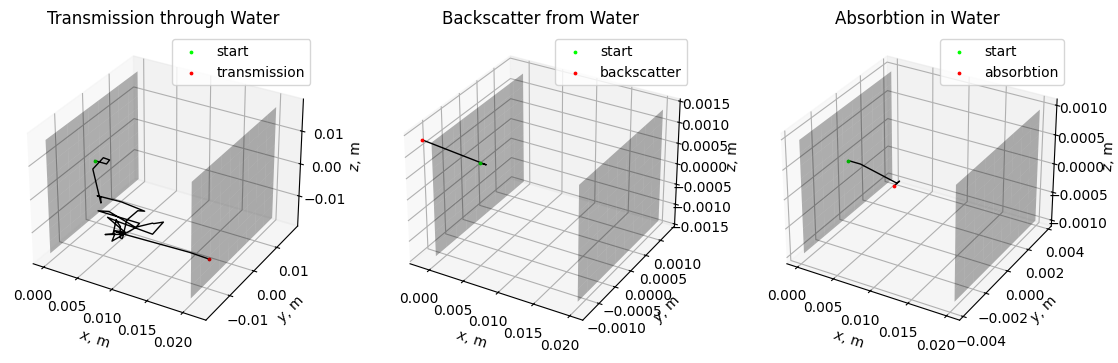

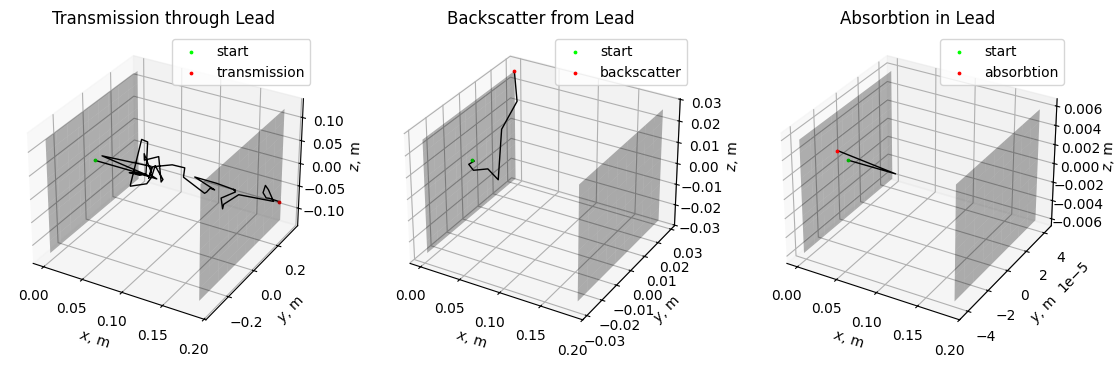

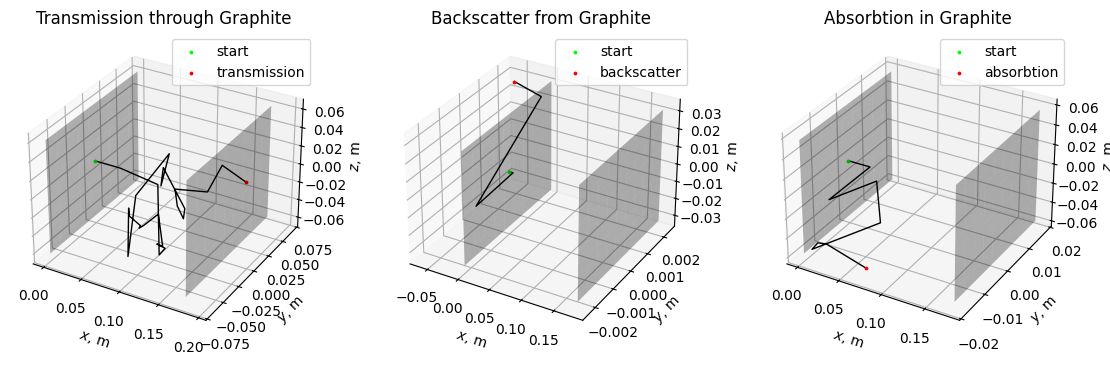

In [15]:
def neutron_random_walk(thickness, mean_free_path, p_absorb):
    '''
    Generates the coordinates for a random walk of a neutron initially travelling into the slab of sheilding material in the
    positive x direction. The walk stops if the neutron is transmitted through the entire thickness of the material, is 
    backscattered or absorbed, where the probability of absorbtion is given by p_absorb.
    
    Parameters:
    thickness: float
    mean_free_path: float
    p_absorb: float
    
    Returns:
    x_coords: array of floats
    y_coords: array of floats
    z_coords: array of floats
    '''
    #set number of transmissions, reflections and absorbtions to zero initially
    N_T = 0
    N_R = 0
    N_A = 0
    
    #generate first coordinate as in the positive x direction with an exponentially distributed randomly generated magnitude
    x_coords = np.append(np.array([0]), exponential_number_generator(1, mean_free_path))
    y_coords = np.array([0,0])
    z_coords = np.array([0,0])
    
    #only keep generating points if the neutron is within the boundaries of the shielding material
    while 0 < x_coords[-1] < thickness:
        x_coords = np.append(x_coords, x_coords[-1] + isotropic_exponential_vectors(1, mean_free_path)[0])
        y_coords = np.append(y_coords, y_coords[-1] + isotropic_exponential_vectors(1, mean_free_path)[1])
        z_coords = np.append(z_coords, z_coords[-1] + isotropic_exponential_vectors(1, mean_free_path)[2])
        
        #if neutron is absorbed, stop random walk
        if np.random.uniform(0,1,1) < p_absorb:
            return x_coords, y_coords, z_coords
            break
    return x_coords, y_coords, z_coords

def plot_random_walks(thickness, mean_free_path, p_absorb, material):
    '''
    Plots randomly generated paths that correspond to neutron transmission, backscatter and absorbtion for a given thickness
    of shielding material, which has mean free path mean_free_path and probability of absorbtion p_absorb. Plots visualise
    edges of the shielding material with semi transparent planes.
    
    Parameters:
    thickness: float
    mean_free_path: float
    p_absorb: float
    material: str
    '''
    #set up subplots
    plt.rcParams.update({'font.size':10})
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax = plt.subplots(1, 3, subplot_kw={'projection':'3d'})
    
    #generate random walk that ends in transmission
    x = np.array([0])
    while x[-1] < thickness:
        x, y, z = neutron_random_walk(thickness, mean_free_path, p_absorb)
        
    #plot random walk, start and end point
    ax[0].plot(x, y, z, c = 'black', linewidth = 1)
    ax[0].scatter(x[0], y[0], z[0], c = 'lime', s = 3, label = 'start')
    ax[0].scatter(x[-1], y[-1], z[-1], c = 'red', s = 3, label = 'transmission')
    ax[0].set_title(f'Transmission through {material}')
    
    #create and plot planes to represent boundaries of shielding layer
    yy, zz = np.meshgrid(np.linspace(-np.max(np.abs(y)),np.max(np.abs(y)), 10), 
                         np.linspace(-np.max(np.abs(z)),np.max(np.abs(z)), 10))
    ax[0].plot_surface(thickness, yy, zz,  alpha = 0.3, color = 'black')
    ax[0].plot_surface(0, yy, zz,  alpha = 0.3, color = 'black')
    
    #generate random walk that ends in refletion / backscatter
    while x[-1] > 0:
        x, y, z = neutron_random_walk(thickness, mean_free_path, p_absorb)
        
    #plot random walk, start and end point
    ax[1].plot(x, y, z, c = 'black', linewidth = 1)
    ax[1].scatter(x[0], y[0], z[0], c = 'lime', s = 3, label = 'start')
    ax[1].scatter(x[-1], y[-1], z[-1], c = 'red', s = 3, label = 'backscatter')
    ax[1].set_title(f'Backscatter from {material}')
    
    #create and plot planes to represent boundaries of shielding layer
    yy, zz = np.meshgrid(np.linspace(-np.max(np.abs(y)),np.max(np.abs(y)), 10), 
                         np.linspace(-np.max(np.abs(z)),np.max(np.abs(z)), 10))
    ax[1].plot_surface(thickness, yy, zz,  alpha = 0.3, color = 'black')
    ax[1].plot_surface(0, yy, zz,  alpha = 0.3, color = 'black')
    
    #generate random walk that ends in absorbtion
    while not 0 < x[-1] < thickness:
        x, y, z = neutron_random_walk(thickness, mean_free_path, p_absorb)
        
    #plot random walk, start and end point
    ax[2].plot(x, y, z, c = 'black', linewidth = 1)
    ax[2].scatter(x[0], y[0], z[0], c = 'lime', s = 3, label = 'start')
    ax[2].scatter(x[-1], y[-1], z[-1], c = 'red', s = 3, label = 'absorbtion')
    ax[2].set_title(f'Absorbtion in {material}')
    
    #create and plot planes to represent boundaries of shielding layer
    yy, zz = np.meshgrid(np.linspace(-np.max(np.abs(y)),np.max(np.abs(y)), 10), 
                         np.linspace(-np.max(np.abs(z)),np.max(np.abs(z)), 10))
    ax[2].plot_surface(thickness, yy, zz,  alpha = 0.3, color = 'black')
    ax[2].plot_surface(0, yy, zz,  alpha = 0.3, color = 'black')
    
    #set axis labels and legend
    for i in range(3):
        ax[i].set_xlabel('$x$, m')
        ax[i].set_ylabel('$y$, m')
        ax[i].set_zlabel('$z$, m')
        ax[i].legend(loc = 'upper right')
    plt.tight_layout(pad = 5)    
    plt.show()
    return None

#plot transmission, backscatter and absortion for water, lead and graphite shielding layers
#make the thickness of each layer 7 x (total mean free path for that material)
for i in range(len(mfp_total)):
    plot_random_walks(7*mfp_total[i], mfp_total[i], prob_absorb[i], MATERIALS[i])

# 2.3 10cm slab 

Next, we will generate the outcome of 10,000 random walks (or equivalenlty simulate the result of 10,000 neutrons incident normally onto the slab), calculating the number of transmitted, absorbed and reflected neutrons in a 10cm slab of each material. Ten iterations of this simulation are completed, and the mean and unertainty of the proportion of neutrons that are transmitted/absorbed/reflected are calculated. This information is tabulted and in pie charts below.

In [16]:
#define the number of neutrons initally incident onto the slab
number_of_neutrons = 10000

#define the number of times to run the simulation to average over
number_of_iterations = 10

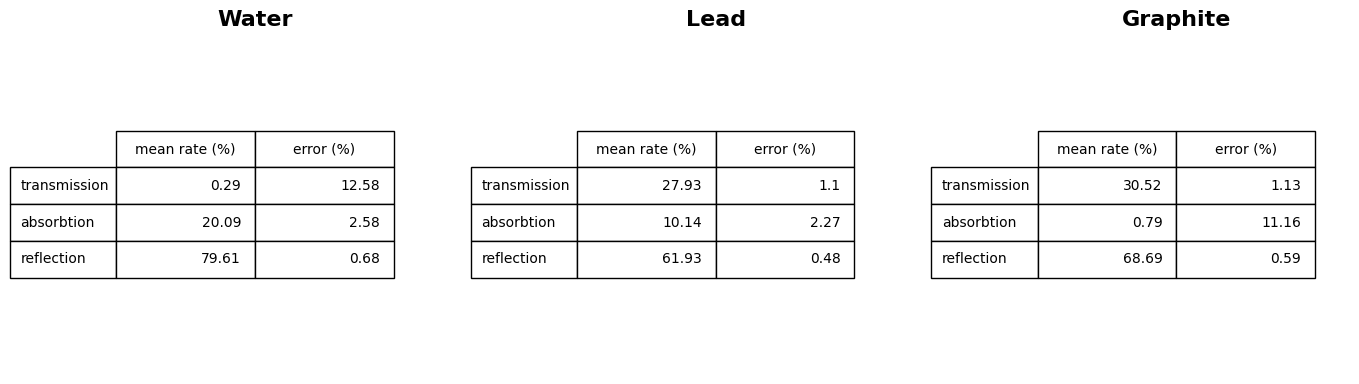

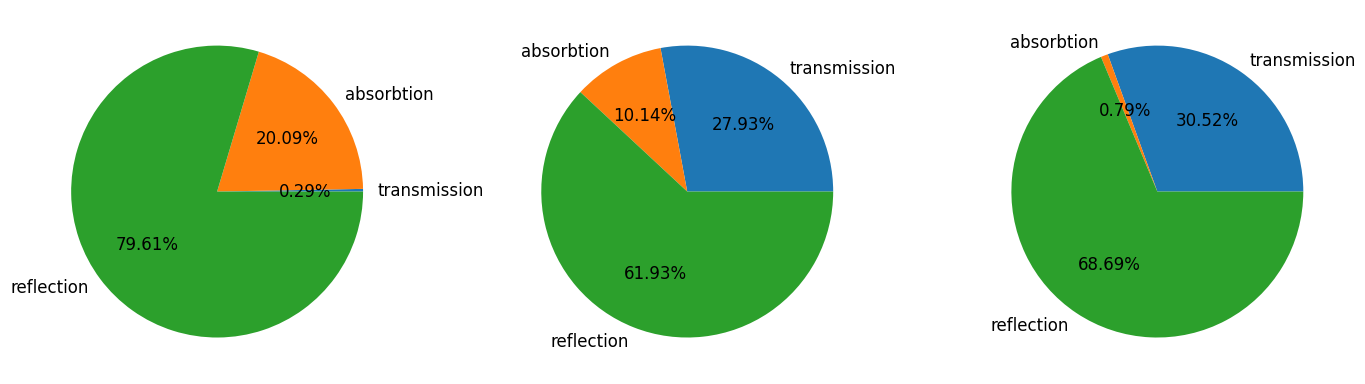

In [23]:
def T_A_R_rates(neutron_number, thickness, mean_free_path, p_absorb):
    '''
    Determines the transmission, absorbtion and reflection rates for a neutron_number neutrons incident onto a material
    with specified thickness, mean_free_path and p_absorb probability of absorbtion.
    
    Parameters:
    neutron_number: int
    thickness: float
    mean_free_path: float
    p_absorb: float
    
    Returns:
    transmission_rate: float
    absorbtion_rate: float
    reflection_rate: float
    '''
    #initially, no particles have been transmitted, reflected or absorbed
    #transmission, reflection and absorbtion tallies are all zero
    N_T = 0
    N_R = 0
    N_A = 0
    
    #create exponentially distributed array of step sizes for inital step in the positive x direction
    #all the neutrons take this first step, so the length of this array acts as the number of neutrons still 'in' the system
    X = exponential_number_generator(neutron_number, mean_free_path)
    
    #keep adding steps untill all neutrons are either transmitted, absorbed or reflected
    while len(X) > 0:
        n = np.random.uniform(size = len(X))

        #if neutron passes through entire thickness of material, add count to transmission tally
        N_T += np.count_nonzero(X > thickness)
        
        #if neutron passes backward through initial boundary of slab, add count to reflection tally
        N_R += (np.count_nonzero(X < 0))
        
        #generate random number between 0 and 1 for all remaining neutrons
        #if this number is less than the probability of absorbtion, say neutron is absorbed and add count to absorbtion tally
        N_A += np.count_nonzero(n[np.argwhere((X>0) & (X<thickness))] < p_absorb)
        
        #omit transmitted, reflected or absorbed neutrons from array of all neutrons (X)
        X = np.delete(X, np.argwhere((X < 0)|(X>thickness)|(n<p_absorb)))
        
        #for remaining neutrons, add isotropic exponentially distributed step and repeat loop
        X += isotropic_exponential_vectors(len(X), mean_free_path)[0]
        
    #calculate transmission, absorbtion af reflection rates
    transmission_rate = N_T / neutron_number
    absorbtion_rate = N_A / neutron_number
    reflection_rate = N_R / neutron_number
    
    return transmission_rate, absorbtion_rate, reflection_rate

def T_A_R_mean_and_error(number_of_repeats, neutron_number, thickness, mean_free_path, p_absorb, all_errors = False):
    '''
    Calculates the mean transmission, absorbtion and reflected rates in an array, and the associated error for transmission 
    rate. If specified, the errors associated with reflection and absorbtion are also calcilates. The number_of_repeats to 
    average over is specified, along with characteristics of the sheilding material.
    
    Parameters:
    number_of_repeats: int
    neutron_number_ int
    thickness: float
    mean_free_path: float
    p_absorb: float
    all_errors: boolean variable
    
    Returns:
    mean_rates: 1D array of floats
    rates_error_transmission: float
    rate_errors: 1D array of floats
    '''
    #create empty array
    rates = np.empty((0, 3))
    
    #create master array of all transmission, absorbtion and reflection rates for each repeat
    for i in range(number_of_repeats):
        rates_temp = np.array([T_A_R_rates(neutron_number, thickness, mean_free_path, p_absorb)])
        rates = np.vstack((rates, rates_temp))
    
    #calculate mean of transmission, absorbtion and reflection rates, and error for transmission
    mean_rates = np.mean(rates, axis = 0)
    rates_error_transmission = np.std(rates[:,0], axis = 0) / mean_rates[0]
    
    #only generate transmission rate error if all_errors = False
    if all_errors == False: 
        return mean_rates, rates_error_transmission
    
    #if all_errors is True, generate errors for transmission, absorbtion and reflection
    else: 
        rates_error_absorbtion = np.std(rates[:,1], axis = 0) / mean_rates[1]
        rates_error_reflection = np.std(rates[:,2], axis = 0) / mean_rates[2]
        rate_errors = np.array([rates_error_transmission, rates_error_absorbtion, rates_error_reflection])
        
        return mean_rates, rate_errors

def plot_table(number_of_repeats, neutron_number, mean_free_path, p_absorb):
    '''
    Plots a table and pie charts containing the mean transmission, absorbtion and reflection rates for thermal neutrons 
    in water, lead and graphite.
    
    Parameters:
    number_of_repeats: int
    neutron_number_ int
    mean_free_path: 1D array of floats
    p_absorb: 1D array of floats
    
    Returns:
    None
    '''
    
    #set up subplots
    fig, ax = plt.subplots(1,3, figsize=(14,4))
    fig2, ax2 = plt.subplots(1, 3, figsize=(14, 10))
    
    #create arrays required
    all_rates = np.empty((0,3))
    all_rate_errors = np.empty((0,3))
    processes = ('transmission', 'absorbtion', 'reflection')
    column_headers = ('mean rate (%)', 'error (%)')
    
    
    for i in range(3):
        #calculate mean rates and errors
        mean_rates = T_A_R_mean_and_error(number_of_repeats, neutron_number, 0.1, mean_free_path[i], 
                                          p_absorb[i], all_errors = True)[0] *100
        rate_errors = T_A_R_mean_and_error(number_of_repeats, neutron_number, 0.1, mean_free_path[i], 
                                           p_absorb[i], all_errors = True)[1] *100
        
        #lay out table data
        table_data = np.array([[mean_rates[0], rate_errors[0]], \
                              [mean_rates[1], rate_errors[1]], \
                              [mean_rates[2], rate_errors[2]]])
        
        #plot table
        table = ax[i].table(cellText=np.round(table_data, decimals=2),
                                       rowLabels=processes,
                                       colLabels=column_headers,
                                       loc='center',
                                       colWidths=[0.2 for x in column_headers])
        #add details to table
        ax[i].axis('off')
        ax[i].set_title(f'{MATERIALS[i]}', fontweight='bold', fontsize=16)
        table.scale(2,2)
        
        #plot pie charts
        ax2[i].pie(mean_rates, labels=processes, autopct='%1.2f%%') 
    
    fig2.tight_layout()
    fig.tight_layout()
    plt.show() 
    return None    
  
plot_table(number_of_iterations, number_of_neutrons, mfp_total, prob_absorb)

The proecesses with the smallest rates have the largest errors, as errors are scaled by the mean transmission rates. Therefore the error associated with low transmission rates is inflated.

# 2.4 Neutron behavior in different slab thickness


We will now investigate the rates of transmission, absorbtion and reflection for slabs of different thicknesses.

In [24]:
#define thicknesses of slab to investigate
thicknesses = np.linspace(0, 0.2, 12), np.linspace(0.0, 0.2, 12), np.linspace(0.0, 0.2, 12)

[codecarbon WARNING @ 12:21:05] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 12:21:05] [setup] RAM Tracking...
[codecarbon INFO @ 12:21:05] [setup] CPU Tracking...


[codecarbon WARNING @ 12:21:07] We saw that you have a 12th Gen Intel(R) Core(TM) i5-1235U but we don't know it. Please contact us.
[codecarbon WARNING @ 12:21:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 12:21:07] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i5-1235U
[codecarbon WARNING @ 12:21:07] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:21:07] [setup] GPU Tracking...
[codecarbon INFO @ 12:21:07] No GPU found.
[codecarbon INFO @ 12:21:07] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:21:07] >>> Tracker's metadata:
[codecarbon INFO @ 12:21:07]   Platform system: Windows-11-10.0.26100-SP0
[codecarbo

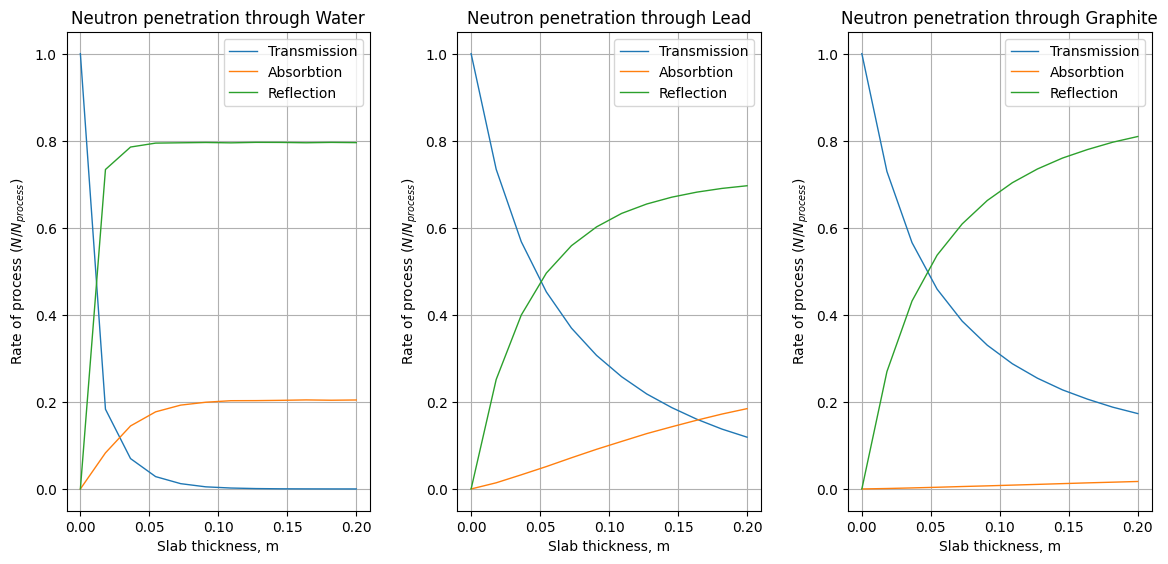

[codecarbon INFO @ 12:22:10] Energy consumed for RAM : 0.000165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:22:10] Delta energy consumed for CPU with constant : 0.000169 kWh, power : 42.5 W
[codecarbon INFO @ 12:22:10] Energy consumed for All CPU : 0.000700 kWh
[codecarbon INFO @ 12:22:10] 0.000865 kWh of electricity used since the beginning.


=====done=====


In [43]:
def T_A_R_thicknesses(thicknesses, neutron_number, mean_free_path, p_absorb):
    '''
    Determines the mean transmission, absorbtion and reflection rates and associated uncertainty of transmission for a range
    of thicknesses in a given material of specified mean_free_path and p_absorb.
    
    Parameters:
    thicknesses: 1D array of floats
    neutron_numnber: int
    mean_free_path: float
    p_absorb: float
    
    Returns:
    T_A_R_array: 2D array of floats
    T_errors: 2D array of floats
    '''
    #create empty arrays
    T_A_R_array = np.empty((0,3))
    T_errors = np.empty((0,1))
    
    #calculate mean and error for each thickness and add to empty array
    for i in range(len(thicknesses)):
        T_A_R_array_temp, T_errors_temp = T_A_R_mean_and_error(10, neutron_number, thicknesses[i], mean_free_path, p_absorb)
        T_A_R_array = np.vstack((T_A_R_array, T_A_R_array_temp))
        T_errors = np.vstack((T_errors, T_errors_temp))
        
    return T_A_R_array, T_errors

def plot_T_A_R_thicknesses(thicknesses, neutron_number, mean_free_paths, p_absorbs):
    '''
    Plots the transmission, absorbtion and reflection rates for a range of thicknesses of water, graphite and lead. Also
    returns an array of transmission rates and errors to be used later.
    
    Parameters:
    thicknesses: 2D array of floats
    neutron_number: int
    mean_free_paths: 1D array of floats
    p_absorbs: 1D array of floats
    
    Returns:
    transmission_master_array: 2D array of floats
    transmission_err_master_array: 2D array of floats
    '''
    #set up subplots
    plt.rcParams.update({'font.size':10})
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax = plt.subplots(1, 3)
    
    #define processes for titles of plots
    process = ('Transmission', 'Absorbtion', 'Reflection')
    
    #create empty master arrays for mean transmission and error
    transmission_master_array, transmission_err_master_array = np.empty(
        (0, len(thicknesses[0]))), np.empty((0, len(thicknesses[0])))
    
    #calculate transmission, absorbtion and reflection rates and errors for each thickness for each material
    #also add transmission rates and errors to master array for all materials
    for i in range(3):
        T_A_R_array, T_errors = T_A_R_thicknesses(thicknesses[i], neutron_number, mean_free_paths[i], p_absorbs[i])
        transmission_master_array = np.vstack((transmission_master_array, T_A_R_array[:,0]))
        transmission_err_master_array = np.vstack((transmission_err_master_array, T_errors[:,0]))
        
        #title each plot
        ax[i].set_title(f'Neutron penetration through {MATERIALS[i]}')
        
        colors = ('midnightblue', 'firebrick', 'darkslategray')
        
        #plot transmission, absorbtion and reflection rates over a range of thicknesses 
        #no error bars are included as this is just to show the shape of the function
        for j in range(3):
            ax[i].plot(thicknesses[i], T_A_R_array[:,j], label = process[j], linewidth = 1)
        
        #add details to each plot
        ax[i].legend()
        ax[i].grid()
        ax[i].set_xlabel('Slab thickness, m')
        ax[i].set_ylabel('Rate of process ($N/N_{process}$)')
        
    plt.tight_layout(pad = 2)    
    plt.show() 
    
    return transmission_master_array, transmission_err_master_array
 
from codecarbon import EmissionsTracker

with EmissionsTracker(output_file="neutron_penetration_emissions_80000.csv") as tracker:
    transmission_master_array, transmission_errors_master_array = plot_T_A_R_thicknesses(
        thicknesses, 80000, mfp_total, prob_absorb)
print("=====done=====")

These plots demonstrate decreasing transmission rate as slab thickness increases, but increasing reflection and absorbtion rates as slab thickness increases. However, this is not linear. Rates appear to increase/decrease exponentially with a plateau at large thicknesses (this is most clearly seen in the plot for water). This idea is investigated in the next section below.

Error bars were not included in the above plots. These plots aim to qualitatively demontrate the shape of the changing transmission, absorbtion and reflection rates. Errors are included in calculations and plots when quantitatively investigating the exponential nature of transmission rate as below.

# 2.5  Determiniming the characteristic attenuation length

The characteristic attenuation length $T_c$ of a material is defined as the thickness of a slab of shielding material that transmits $\frac{1}{e}$ of the original intensity of the neutron beam. This can be described by the equation

$$\frac{N_T}{N} = e^{\frac{-t}{T_c}},\quad (5)$$

where $N_T$ is the number of transmitted neutrons through a slab of thickness $t$ and $N$ is the number of neutrons entering the slab. In order to calculate $T_c$ for all three materials investigated, equation () is linearised to the form

$$\ln(\frac{N_T}{N}) = (-\frac{1}{T_c}) t, \quad (6)$$

and thickness $t$ is plotted against $\ln{\frac{N_T}{N}}$. A straight line is fitted to data points and the gradient is used to calculate the characteristic attenutatiuon length $T_c$.

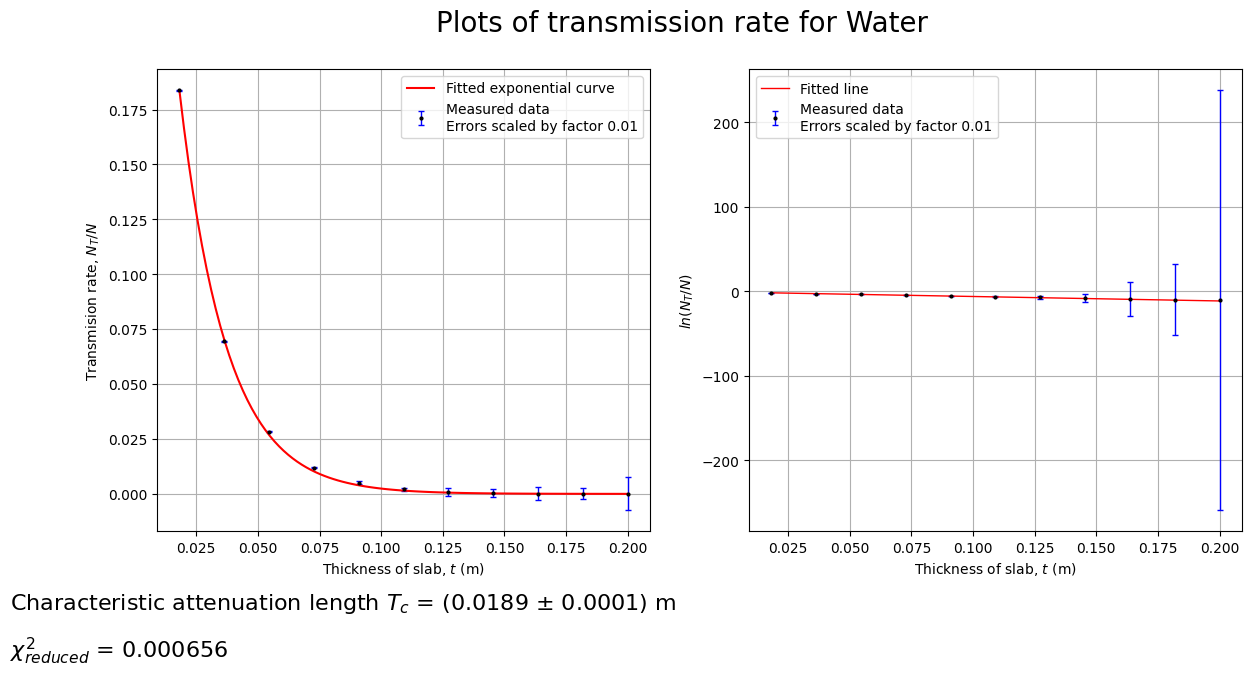

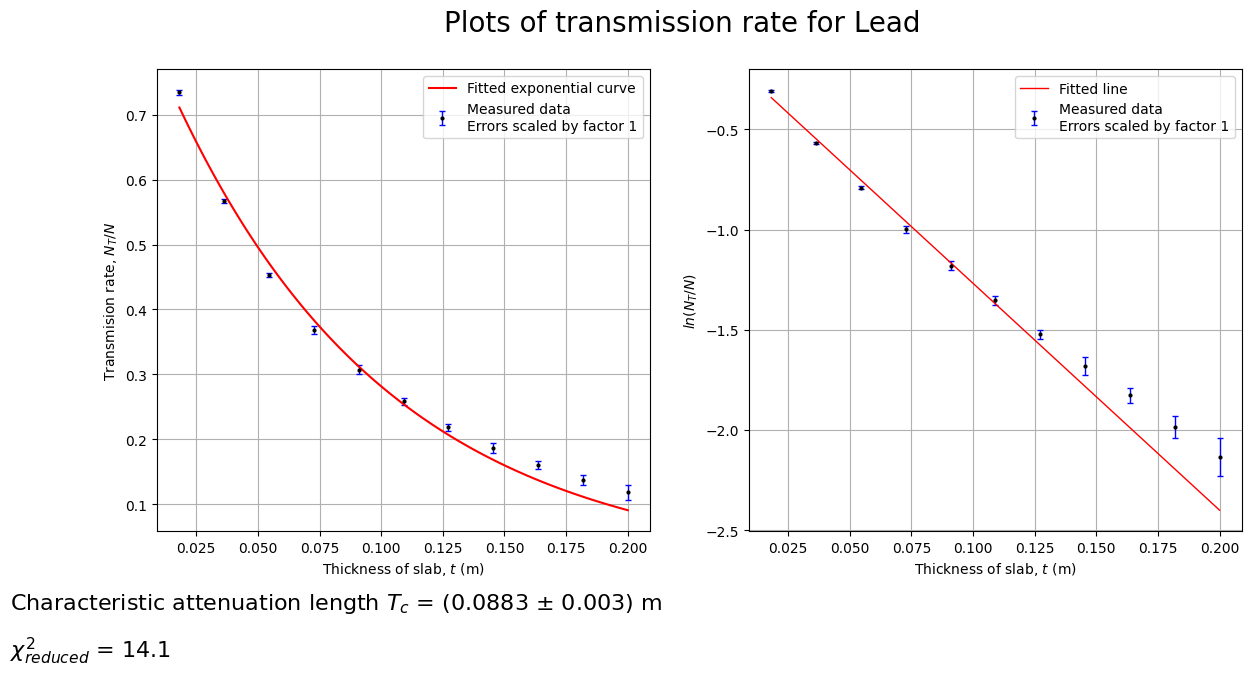

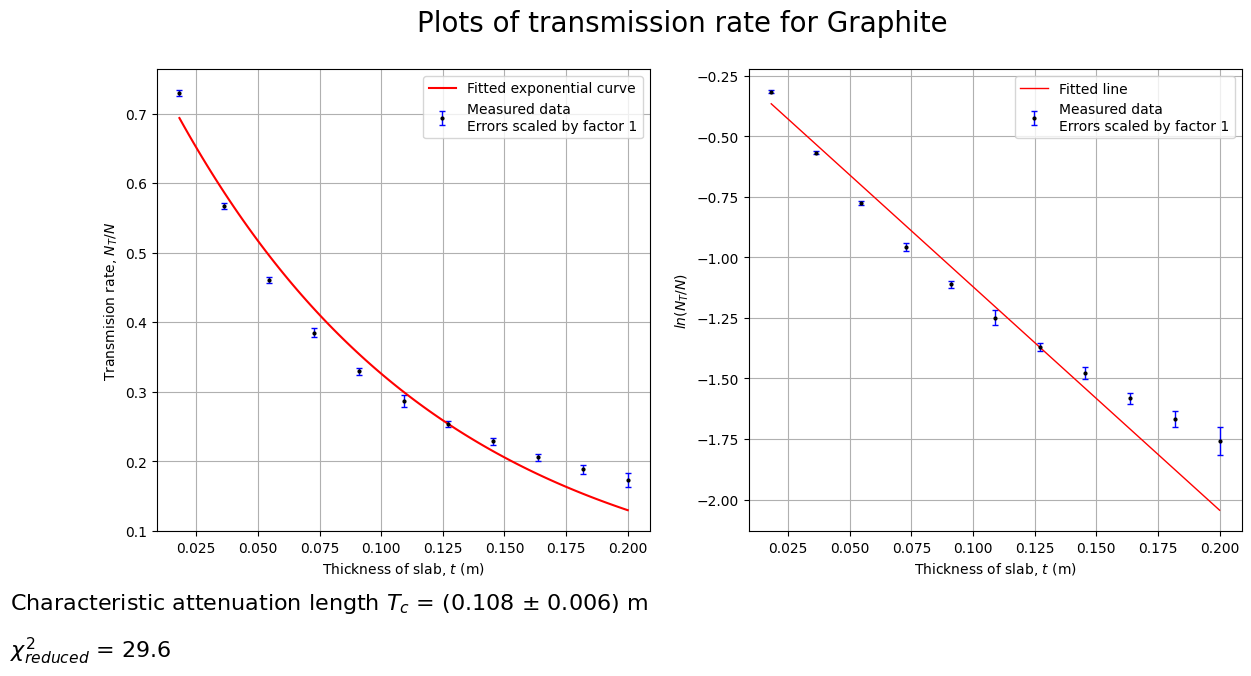

In [27]:
def plot_transmission_rates(mean_t, t_error, thicknesses, material, error_factor):
    '''
    Plots the transmission rates vs thickness, alongside a linearised version of this according to equation 6. The transmission
    rates and errors are taken from the plot in section 2.3. A linear fit is performed, and from this the characteristic
    attenuation length is calulated. A reduced chi squared test is performed on the linear fit. The parameters determined from
    the linear fit are used to plot an exponential curve.
    
    Parameters:
    mean_t: 1D array of floats
    t_error: 1D array of floats
    thicknesses: 1D array of floats
    material: 1D array of strings
    
    Returns:
    None
    '''
    
    #thicknesses = np.append(0, thicknesses)
    #set up plot
    plt.rcParams["figure.figsize"] = (14,6)
    fig, ax =  plt.subplots(1,2)
    fig.suptitle(f'Plots of transmission rate for {material}', fontsize = 20)

    #delete values where the error on transmission = 0 
    mean_t = mean_t[t_error != 0]
    thicknesses = thicknesses[t_error != 0]
    t_error = t_error[t_error != 0]
    
    #error associated with ln(x) is the fractional error of x
    ln_t_error = t_error/mean_t
    
    #calculate parameters and errors associated with linear fit
    (gradient, intercept), cov_matrix = np.polyfit(thicknesses, np.log(mean_t), 1, w = (1/ln_t_error), cov=True)
    T_c = -1 / gradient
    gradient_error = np.sqrt(np.diag(cov_matrix)[0])
    T_c_err = np.sqrt(T_c**2 * gradient_error**2 / gradient**2)
    initial_t_rate = np.exp(intercept)
    fit = np.polyval((gradient, intercept), thicknesses)
    
    #create array of thicknesses to plot exponential fit for
    thicknesses_for_exponential = np.linspace(thicknesses[0], thicknesses[-1], 100)
    
    #calculate values for the exponential fit
    exponential_fit = initial_t_rate * np.exp(- thicknesses_for_exponential / T_c)
    
    #plot transmission rates and fitted exponential curve
    ax[0].errorbar(thicknesses, mean_t, yerr = t_error * error_factor, fmt = 'o', color = 'black', markersize = 2, 
                   capsize = 2, linewidth =1, ecolor ='blue', label = f'Measured data \nErrors scaled by factor {error_factor}')
    ax[0].plot(thicknesses_for_exponential, exponential_fit, c = 'red', label = 'Fitted exponential curve')
    ax[0].set_ylabel('Transmision rate, ${N_T}/{N}$')
    
    #plot ln(transmission rate) and linearised fit
    ax[1].errorbar(thicknesses, np.log(mean_t), yerr = ln_t_error*error_factor, fmt = 'o', color = 'black', markersize = 2, 
                   capsize = 2, linewidth =1, ecolor ='blue', label = f'Measured data \nErrors scaled by factor {error_factor}')
    ax[1].plot(thicknesses, fit, c = 'red', linewidth = 1, label = 'Fitted line')
    ax[1].set_ylabel('$ln({N_T}/{N})$')
    
    #add plot details
    for i in range(2):
        ax[i].grid()
        ax[i].legend()
        ax[i].set_xlabel('Thickness of slab, $t$ (m)')
       
    #add the attenutation length and chi squared values to plots
    fig.text(0.02, -0.02, rf'Characteristic attenuation length $T_c$ = ({T_c:2.3} $\pm$ {T_c_err:2.1}) m', fontsize = 16)
    reduced_chi_sq = reduced_chi_squared(np.log(mean_t), ln_t_error, fit)
    fig.text(0.02, -0.1, r'$\chi_{reduced}^2$' + f' = {reduced_chi_sq:2.3}', fontsize = 16)
    plt.show()
    return None

#plot transmission rates for all three materials

error_factors = (0.01, 1 , 1)

for i in range(3):
    plot_transmission_rates(transmission_master_array[i], transmission_errors_master_array[i], thicknesses[i], 
                            MATERIALS[i], error_factors[i])

When investigating water, there is a very small $\chi_{reduced}$ value. This is due to large errors in the transmission rates for larger thicknesses. Again, errors were scaled to the mean transmission rate for each slab width, so very small transmission rates have large errors. As the characteristic attenuation length of water is smallest, there are more widths were transmission is very low and so this plot has the largest error bars and smallest $\chi_{reduced}$ value. 



# 3 Woodcock Method

When working with a multiple layer shileding material, the previously explored method become computationally expensive and inefficient. This is because, after each step, a geometric check has to be done to determine whether or not the neutron has passed through to the second layer of material, which has a different mean free path and scattering/absorbtion cross section to the first layer. This requires many computational steps. In order to combat this and improve the efficiency of a multi-layer neutron penetration simulation, the Woodcock method is implemented.

The woodcock method works by taking steps of sizes scaled to the mean free path of the material with the largest total cross-section $\Sigma_T = \Sigma_{absorbtion} + \Sigma_{scatter}$ (the primary material). This means that steps taken in the other secondary material will be 'too short'. In order to combat this, ficticious steps are used. For the majority of steps inside the secondary slab, the direction of each step doesnt change. There is a small probability of scattering/absorbtion inside the secondary material.

# 3.1 Random walk of multi-layer slab

The random walk for a neutron incident onto a multi layer slab containing lead and graphite is visulised below using the Woodcock method. Scenarios where the neutron is both transmitted and backscattered are shown.

In [28]:
#define the thickness of each layer inside the slab
thickness_of_each_layer = 0.1 # metre

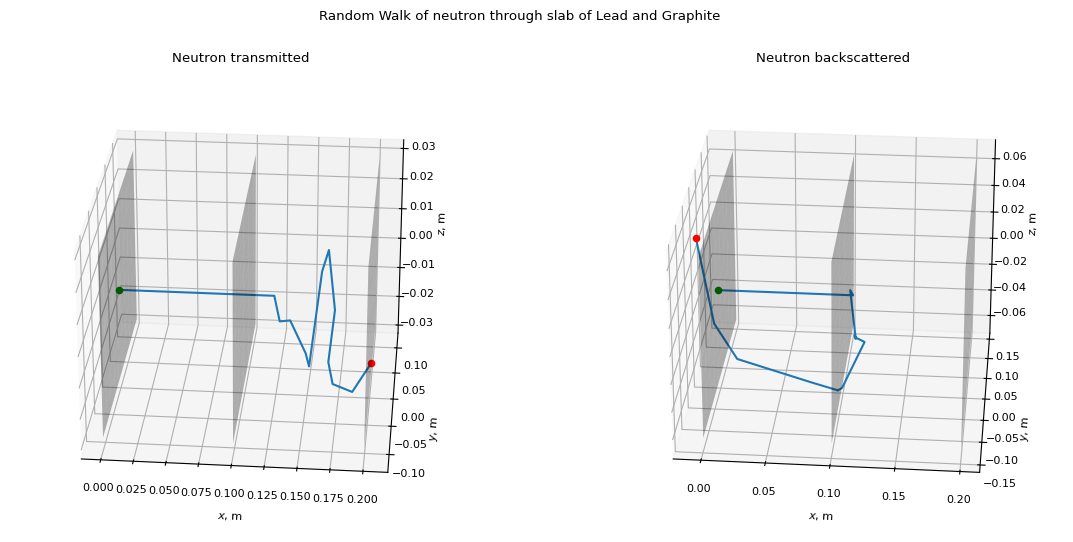

In [29]:
def cartesian_to_polar(x,y,z):
    '''
    Generates the polar coordinates of vectors from the cartesian coordinates.
    
    Parameters:
    x: 1D array of floats
    y: 1D array of floats
    z: 1D array of floats
    '''
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.arccos(x / (r * np.sin(theta)))
    return r, theta, phi

def woodcock_method(macro_absorbtions, macro_scatters, mfp_totals, thickness_of_each, absorbtion_probs, materials):
    '''
    Generates the coordinates for a random walk of a thermal neutron entering a multi layer slab, according to the 
    Woodcock method.
    
    Parameters:
    macro_absorbtions: 1D array of floats (length  = 2)
    macro_scatters: 1D array of floats (length  = 2)
    mfp_totals: 1D array of floats (length  = 2)
    thickness_of_each: float
    absorbtion_probs: 1D array of floats (length  = 2)
    materials: 1D array of strings (length  = 2)
    
    Returns:
    x_coords: 1D array of floats
    y_coords: 1D array of floats
    z_coords: 1D array of floats
    material_1: str
    material_2: str
    result: str
    '''
    
    #calculate which slab has the maximum mean free path, and let this be the first material in the multi layer slab
    material_1_index = np.argwhere(mfp_totals == np.max(mfp_totals))
    material_2_index =  np.argwhere(mfp_totals == np.min(mfp_totals))
    
    #determine the material, mean free path, total cross-section and absorbtion probability of the 1st and 2nd slab materials
    material_1 = materials[material_1_index]
    material_2 = materials[material_2_index]
    mean_free_path2 = mfp_totals[material_2_index]
    mean_free_path1 = mfp_totals[material_1_index]
    total_cs_min = (macro_absorbtions + macro_scatters)[material_1_index]
    total_cs_max = (macro_absorbtions + macro_scatters)[material_2_index]
    p_absorb_1 = absorbtion_probs[material_1_index]
    p_absorb_2 = absorbtion_probs[material_2_index]
    
    #generate first coordinate as in the positive x direction with an exponentially distributed randomly generated magnitude
    x_coords = np.append(np.array([0]), exponential_number_generator(1, mean_free_path2))
    y_coords = np.array([0,0])
    z_coords = np.array([0,0])
    
    #define initial direction of any ficticious steps
    random_vector = (1,0,0)
    
    #only keep generating points if the neutron is within the boundaries of the shielding material
    while 0 < x_coords[-1] < 2*thickness_of_each:
        #first deal with neutrons inside the first material
        if x_coords[-1] < thickness_of_each:
            
            if np.random.uniform(0,1,1) < total_cs_min/total_cs_max:
                #generate ficticious step of random exponentially generated length
                r, theta, phi = cartesian_to_polar(random_vector[0], random_vector[1], random_vector[2])
                random_exponential_r = exponential_number_generator(1, mean_free_path2)
                
                x_coords = np.append(x_coords, x_coords[-1] + polar_to_cartesian(
                    theta, phi, random_exponential_r)[0])
                y_coords = np.append(y_coords, y_coords[-1] + polar_to_cartesian(
                    theta, phi, random_exponential_r)[1])
                z_coords = np.append(z_coords, z_coords[-1] + polar_to_cartesian(
                    theta, phi, random_exponential_r)[2])
            #if randomly generated number > the cross-section of material 1 / cross-section of material 2
            #neutron is scattered or absorbed inside material one.
            #decide if neutron is scattered or absorbed (and if absorbed, terminate the walk)
            else:
                if np.random.uniform(0,1,1) < p_absorb_1:
                    print('absorbed in 1')
                    return x_coords, y_coords, z_coords
                    break
                else:
                    #add scattering step 
                    random_vector = isotropic_exponential_vectors(1, mean_free_path2)
                    x_coords = np.append(x_coords, x_coords[-1] + random_vector[0])
                    y_coords = np.append(y_coords, y_coords[-1] + random_vector[1])
                    z_coords = np.append(z_coords, z_coords[-1] + random_vector[2])
                    
        #now deal with the case where the neutron has travelled into material 2
        else:  
            
            #if neutron is absorbed, stop random walk
            if np.random.uniform(0,1,1) < p_absorb_2:
                print('absorbed in 2')
                return x_coords, y_coords, z_coords
                break 
            
            #if neutron not absorbed, add scattering step
            else:
                random_vector = isotropic_exponential_vectors(1, mean_free_path2)
                x_coords = np.append(x_coords, x_coords[-1] + random_vector[0])
                y_coords = np.append(y_coords, y_coords[-1] + random_vector[1])
                z_coords = np.append(z_coords, z_coords[-1] + random_vector[2])
                
    if x_coords[-1] < 0:
        result = 'backscattered'
    if x_coords[-1] > 2*thickness_of_each:
        result = 'transmitted'
    if 0 < x_coords[-1] < thickness_of_each:
        result = f'absorbed inside {material_1}'
    if thickness_of_each < x_coords[-1] <2*thickness_of_each:
        result = f'absorbed inside {material_2}'
        
    return x_coords, y_coords, z_coords, material_1, material_2, result

def plot_woodcock_random_walk(macro_cs_a, macro_cs_s, mfp_total, probs_absorb, thickness_of_each, materials):
    '''
    PLots the random walk of a thermal neutron inside of a multi-layer slab, for scenarios where the neutron is 
    transmitted and backscattered.
    
    Parameters:
    macro_cs_a: 1D array of floats (length  = 2)
    macro_cs_s: 1D array of floats (length  = 2)
    mfp_total: 1D array of floats (length  = 2)
    probs_absorb: 1D array of floats (length  = 2)
    thickness_of_each: float
    materials: 1D array of strings (length  = 2)
    
    Returns:
    None
    '''
    #set up plot
    plt.rcParams.update({'font.size':8})
    fig, ax = plt.subplots(1, 2, subplot_kw={'projection':'3d'})
    plt.rcParams["figure.figsize"] = (12,6)
    fig.suptitle(f'Random Walk of neutron through slab of {materials[0]} and {materials[1]}')
    
    #generate coordinates of random walk that ends in transmission, and order of materials in slab
    x = np.array([0])
    while x[-1] < 2*thickness_of_each:
        x, y, z, material_1, material_2, result = woodcock_method(macro_cs_a, macro_cs_s, mfp_total, 
                                                                  thickness_of_each, probs_absorb, materials)

    #plot random walk
    ax[0].plot(x, y, z)

    #plot start and end points
    ax[0].scatter(x[-1], y[-1], z[-1], c = 'red', label = 'start')
    ax[0].scatter(0,0,0, c = 'green', label = 'end')

    #plot suface boundaries
    yy, zz = np.meshgrid(np.linspace(-np.max(np.abs(y)),np.max(np.abs(y)), 10), 
                             np.linspace(-np.max(np.abs(z)),np.max(np.abs(z)), 10))
    ax[0].plot_surface(0.1, yy, zz,  alpha = 0.3, color = 'black')
    ax[0].plot_surface(0, yy, zz,  alpha = 0.3, color = 'black')
    ax[0].plot_surface(0.2, yy, zz,  alpha = 0.3, color = 'black')
    ax[0].set_title(f'Neutron {result}')
    
    #generate coordinates of random walk that ends in backscatter, and order of materials in slab
    while x[-1] > 0:
        x, y, z, material_1, material_2, result = woodcock_method(macro_cs_a, macro_cs_s, mfp_total, 
                                                                  thickness_of_each, probs_absorb, materials)

    #plot random walk
    ax[1].plot(x, y, z)

    #plot start and end points
    ax[1].scatter(x[-1], y[-1], z[-1], c = 'red', label = 'start')
    ax[1].scatter(0,0,0, c = 'green', label = 'end')

    #plot suface boundaries
    yy, zz = np.meshgrid(np.linspace(-np.max(np.abs(y)),np.max(np.abs(y)), 10), 
                             np.linspace(-np.max(np.abs(z)),np.max(np.abs(z)), 10))
    ax[1].plot_surface(0.1, yy, zz,  alpha = 0.3, color = 'black')
    ax[1].plot_surface(0, yy, zz,  alpha = 0.3, color = 'black')
    ax[1].plot_surface(0.2, yy, zz,  alpha = 0.3, color = 'black')
    ax[1].set_title(f'Neutron {result}')

    for i in range(2):
        #set axis labels and title
        ax[i].set_xlabel('$x$, m')
        ax[i].set_ylabel('$y$, m')
        ax[i].set_zlabel('$z$, m')
        
        #set initial view so slab boundaries are visible
        ax[i].view_init( 26, -85)
        
    plt.show()
    return None

#define lead and graphite as the slab materials used
materials = MATERIALS[1:]

#create array of macro scattering and absorbtion cross-sections and total mean free path for lead and graphite    
macro_cs_a2, macro_cs_s2, mfp_total2 = macro_cs_a[1:], macro_cs_s[1:], mfp_total[1:]
#create array of probability of absorbtion for lead and graphite
probs_absorb = prob_absorb[1:]

#plot random walk
plot_woodcock_random_walk(macro_cs_a2, macro_cs_s2, mfp_total2, probs_absorb, thickness_of_each_layer, materials)

# 3.2 Transmission through multi-layer slab

A function that calculates the number of transmitted neutrons has been written below. However, the function is not streamlined and returns a RunTimeWarning error. This is due to an error when producing ficticious steps.

In [30]:
def transmission_rates_woodcock(macro_absorbtions, macro_scatters, mfp_totals, thickness_of_each, absorbtion_probs, 
                                materials, neutron_number):
    
    #calculate which slab has the maximum mean free path, and let this be the first material in the multi layer slab
    material_1_index = np.argwhere(mfp_totals == np.max(mfp_totals))
    material_2_index =  np.argwhere(mfp_totals == np.min(mfp_totals))
    
    #determine the material, mean free path, total cross-section and absorbtion probability of the 1st and 2nd slab materials
    material_1 = materials[material_1_index]
    material_2 = materials[material_2_index]
    mean_free_path2 = mfp_totals[material_2_index]
    mean_free_path1 = mfp_totals[material_1_index]
    total_cs_min = (macro_absorbtions + macro_scatters)[material_1_index]
    total_cs_max = (macro_absorbtions + macro_scatters)[material_2_index]
    p_absorb_1 = absorbtion_probs[material_1_index]
    p_absorb_2 = absorbtion_probs[material_2_index]
    N_T = 0
    
    #uniform_array = np.random.uniform(size = neutron_number)
    #X = - mean_free_path2 * np.log(uniform_array)
    X = exponential_number_generator(neutron_number, mean_free_path2)[0]
    random_vector = np.full((len(X), 3), [1, 0, 0])

    while len(X) > 0:
        
        #if neutron passes through entire thickness of material, add count to transmission tally
        N_T += np.count_nonzero(X > 2*thickness_of_each)
        
        n1 = np.random.uniform(0,1,len(X)) 
        n2 = np.random.uniform(0,1,len(X))
        n3 = np.random.uniform(0,1,len(X))
        
        deletions = np.argwhere((X<0) | (X>2*thickness_of_each) | ((X<thickness_of_each)&(n1>total_cs_min/total_cs_max)&(n2<p_absorb_1)) | ((X>thickness_of_each)&(n3<p_absorb_2))).flatten()
        
        random_vector = np.delete(random_vector, deletions, axis = 0)
        X = np.delete(X, deletions)
        n1 = np.delete(n1, deletions)
        n2 = np.delete(n2, deletions)
        n3 = np.delete(n3, deletions)
        
        random_vector_ficticious = random_vector[np.argwhere((X<thickness_of_each)&(n1<total_cs_min/total_cs_max)).flatten(), :]
        #if it is ficticious step add same directional vector
        r, theta, phi = cartesian_to_polar(random_vector_ficticious[:,0], random_vector_ficticious[:,1], random_vector_ficticious[:,2])
        random_exponential_r = exponential_number_generator(len(random_vector_ficticious))

        #add ficticious steps
        X[np.argwhere((X<thickness_of_each)&(n1<total_cs_min/total_cs_max)).flatten()] += polar_to_cartesian(theta, phi, random_exponential_r)[0]
        
        #update scattering vectors
        list_of_scatters = X[np.argwhere(((X<thickness_of_each)&(n1>total_cs_min/total_cs_max)) | (X>thickness_of_each)).flatten()]
        random_x, random_y, random_z = isotropic_exponential_vectors(len(list_of_scatters), mean_free_path2)
        random_vector[np.argwhere(((X<thickness_of_each)&(n1>total_cs_min/total_cs_max)) | (X>thickness_of_each)).flatten(), 0] = random_x
        random_vector[np.argwhere(((X<thickness_of_each)&(n1>total_cs_min/total_cs_max)) | (X>thickness_of_each)).flatten(), 1] = random_y
        random_vector[np.argwhere(((X<thickness_of_each)&(n1>total_cs_min/total_cs_max)) | (X>thickness_of_each)).flatten(), 2] = random_z
        
        #add scattering steps
        X[np.argwhere(((X<thickness_of_each)&(n1>total_cs_min/total_cs_max)) | (X>thickness_of_each)).flatten()] += random_vector[np.argwhere(((X<thickness_of_each)&(n1>total_cs_min/total_cs_max)) | (X>thickness_of_each)).flatten(), 0]
    print(f'The transmission rate for a thermal neutron inside a multi layer slab of {materials[0]} and {materials[1]} is {N_T/neutron_number:1.3}')
        
    return N_T/neutron_number

#i have commented the function as it returns an error, but i have kept my attempt at  functionally implementing the 
#woodcock method

#transmission_rate = transmission_rates_woodcock(macro_cs_a2, macro_cs_s2, mfp_total2, thickness_of_each_layer, probs_absorb, materials, 10)

# Conclusion

Using Monte-Carlo methods, this project generated both uniformly distributed and exponentially distributed isotropic vectors.
Random walks of themral neutrons inside of different slabs have been sucessfully visualised using Monte Carlo methods to simulate the chaotic nature of a neutron's path. By taking the x component of this random walk, and running the simuation for many neutrons over a number of iterations, mean values for the transmission, absorbtion and reflection rate of neutrons can be calculated. By fitting to exponential curves, the characteristic attenuation length of each material was calculated. Finally, the path of a thermal neutron inside a multi-layer slab was investigated using the Woodcock method.